<a href="https://colab.research.google.com/github/cbuie/colab/blob/master/airbnb/Airbnb_lab_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airbnb Analysis London.

## Illustrative Guide to modeling variable importance with Airbnb pricing data.
## Preporocessing the raw data
**The Purpose of this notebook is to construct a repetative data preprocessing pipeline. This notebook can be used to run any city from the Airbnb data set and produce the same/similar (some features may not be relavant for certain locations, e.g. zipcode is not relevant to London) data output for modeling pricing.**
<hr>

The data used for this illustrative analysis is downloaded from [Insideairbnb.com](https://insideairbnb.com/).

According to the source, Inside Airbnb is an independent, non-commercial set of data that allows you to explore how Airbnb is being used in various cities around the world.

By analyzing publicly available information about a city's Airbnb's listings, Inside Airbnb provides filters and key metrics where we can see how Airbnb is being used to compete with the residential housing market.

With Inside Airbnb, you can ask fundamental questions about Airbnb in any neighborhood, or across the city as a whole. Questions such as:

- How many listings are in a neighborhood and where are they?
- What are global (city wide) or local (all the way down to a single unit) historical Airbnb trends 
- How many houses and apartments are being rented out frequently to tourists and not to long-term residents?
- How much are hosts making from renting to tourists (compare that to long-term rentals)
- "Which hosts are running a business with multiple listings and where they?
- etc..

While the data is a rich resource, there are some limitation to using the data. Like nearly evey real dataset, the data quality is fairly poor and requires preprocessing and feature engineering. To utilize as much of the data as we can we will use imputation techniques to fill missing values. 

There are many features in this dataset but many of them are incomplete and either need be refined using imputation or dropped from the analysis. 

This data is similar to our rental data in that the data only consists of advertised price. The advertised prices can be set to any arbitrary amount by the host, and hosts that are less experienced with Airbnb will often set these to very low or very high amounts. This dataset is naive to the actual amount paid on a per night basis. Even with the described limitation, I believe this data to be informative of the Airbnb dynamics of a city. ​

<hr>


# Getting Setup

### Install additional environmental requirements.

- Colab comes preconfigured with the majority of the dependencies needed for this lab, but we need to add a few for exploratory data analysis.



In [0]:
# # Important library for many geopython libraries

# !apt install gdal-bin python-gdal python3-gdal tree
# # Install rtree - Geopandas requirment
# !apt install python3-rtree 
# # Install Geopandas
# !pip install git+git://github.com/geopandas/geopandas.git
# # Install descartes - Geopandas requirment
# !pip install descartes 
# # Install Folium for Geographic data visualization
# !pip install folium
# # Install plotlyExpress
# !pip install plotly_express
# !pip install quilt
# !quilt install ResidentMario/missingno_data

### Mount Google Drive
- For any city we will need two files. 
 - listings.csv.gz
 - neighbourhoods.geojson

I have downloaded these files to Google Drive. In this next step we will need to mount My Drive to our linux virtual machine.


In [113]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load python libraries

In [0]:
# Importing required libraries
import pandas as pd
import numpy as np
import missingno as msno
from IPython.core.display import HTML
from datetime import datetime
import seaborn as sns
import geopandas as gpd
import time
from IPython.display import SVG
import matplotlib.pyplot as plt

plt.style.use('dark_background')
plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "white",
    "axes.facecolor": "#383838",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "#383838",
    "figure.edgecolor": "#383838",
    })
%matplotlib inline

### Load Data:

- You can choose anyway you want to get the data into the environment. From here on the notebook should handle everything the same.



In [0]:
raw_df = pd.read_csv('/content/drive/My Drive/data/london.csv',low_memory=False)
pd.set_option('display.max_rows', 50) #set the number of visible rows
pd.set_option('display.max_columns', 110) #set the number of visible columns

In [116]:
HTML("<h2>Our data has {0} rows and {1} columns.</h2> <p>Let's check our data completeness.</p>".format(raw_df.shape[0],raw_df.shape[1]))

In [117]:
raw_df.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85068 entries, 0 to 85067
Data columns (total 106 columns):
id                                              85068 non-null int64
listing_url                                     85068 non-null object
scrape_id                                       85068 non-null int64
last_scraped                                    85068 non-null object
name                                            85043 non-null object
summary                                         80736 non-null object
space                                           59218 non-null object
description                                     82683 non-null object
experiences_offered                             85068 non-null object
neighborhood_overview                           54694 non-null object
notes                                           32799 non-null object
transit                                         54320 non-null object
access                                          4574

# Processing Data:

### Visualizing missing data across our features.

- Missing Data by Columns, filter to less than 50 to see column names.

Missing Data by Columns, filter to less than 50 to see column names


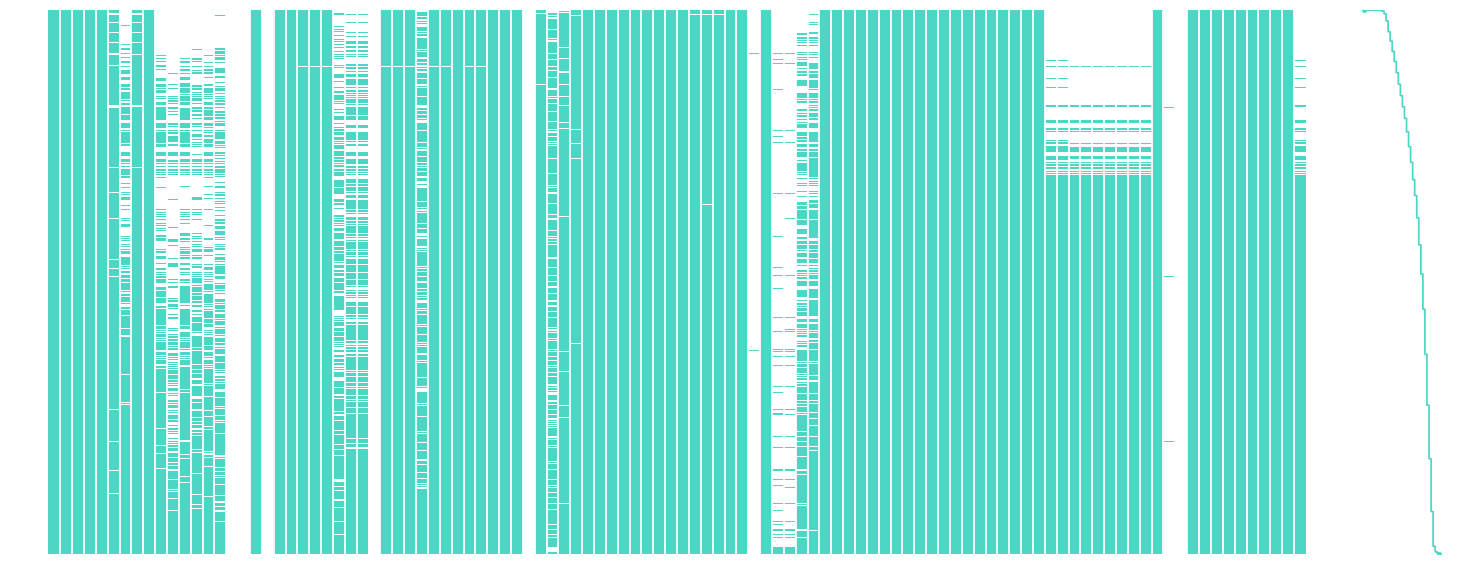

In [118]:

raw_df = raw_df.replace("nan", np.nan)
msno.matrix(raw_df.iloc[:,:raw_df.shape[1]].sample(raw_df.shape[0]),fontsize=9,color=(.3, .84, .77),sort='ascending');
print("Missing Data by Columns, filter to less than 50 to see column names")

## Copy And Drop Unecessary Data:

- Becuase this is an illustrative example we will not be running any Natural Language Processing techniques on the free form text features. However we might be able to enhace our feature set by generating more data from these text features later on if we need to. 




In [0]:
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped']
df = raw_df.drop(cols_to_drop, axis=1).set_index('id',drop=True) #make a copy of our raw data

- There are multiple columns for property location, including an attempt by the site that originally scraped the data to clean up the neighbourhood locations. Some of these columns can be dropped. Because all of the listings are in London, columns relating to city and country can be dropped.

- Because we are looking at a specific city in the same country we can drop redundant location data.

In [0]:
# lat_long = df[['latitude', 'longitude']]
df.drop(['street', 'neighbourhood', 'city', 'market', 'smart_location', 'country_code', 'country', 'is_location_exact'], axis=1, inplace=True)

- Visualizing columns with nulls

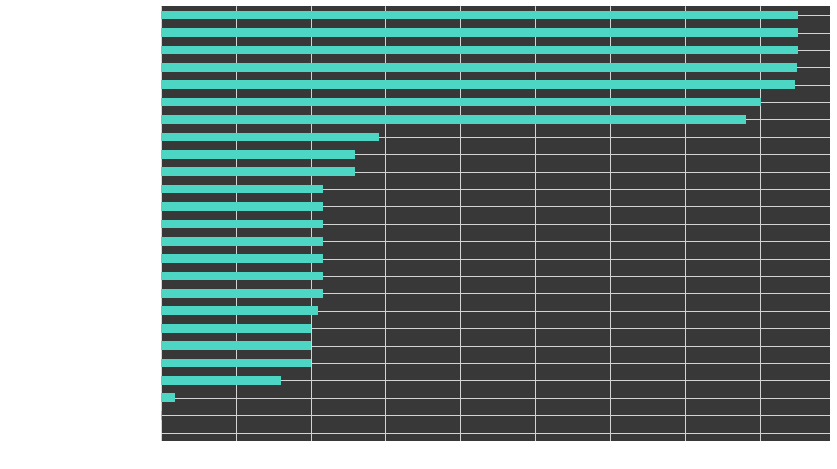

In [121]:
df.isna().sum()[df.isna().sum()>100].sort_values().plot(kind='barh',figsize=(12,8),color=(.3, .84, .77))

In [122]:

missing_val_columns_to_drop = list(df.isna().sum()[df.isna().sum()>1000].index)
missing_val_columns_to_drop.remove('host_response_time') #added back
missing_val_columns_to_drop.remove('host_response_rate') #added back
missing_val_columns_to_drop.remove('cleaning_fee') #added back
missing_val_columns_to_drop.remove('security_deposit') #added back
missing_val_columns_to_drop.remove('first_review') #added back
missing_val_columns_to_drop.remove('review_scores_rating') #added back
missing_val_columns_to_drop.remove('review_scores_accuracy') #added back
missing_val_columns_to_drop.remove('review_scores_cleanliness') #added back
missing_val_columns_to_drop.remove('review_scores_value') #added back
missing_val_columns_to_drop.remove('last_review') #added back
print("columns to drop",pd.DataFrame(missing_val_columns_to_drop))

columns to drop                                0
0           host_acceptance_rate
1   neighbourhood_group_cleansed
2                          state
3                        zipcode
4                    square_feet
5                   weekly_price
6                  monthly_price
7          review_scores_checkin
8    review_scores_communication
9         review_scores_location
10                       license
11            jurisdiction_names
12             reviews_per_month


In [0]:
df.drop(missing_val_columns_to_drop, axis=1, inplace=True)

### Drop repetative columns:

In [124]:
print( "Number of mismatches : ",str(sum((df.host_listings_count == df.host_total_listings_count) == False)))
df.drop(['host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)
# df[["host_listings_count","host_total_listings_count"]]
# df.loc[((df.host_listings_count == df.host_total_listings_count) == False)][:5]
print(df.shape)

Number of mismatches :  12
(85068, 52)


There are multiple columns for minimum and maximum night stays, but the two main ones will be used as there are few differences between e.g. minimum_nights and minimum_minimum_nights. The latter presumably refers to the fact that min/max night stays can vary over the year. The default (i.e. most frequently applied) min/max night stay values will be used instead.

In [125]:
df.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)
print(df.shape)

(85068, 46)


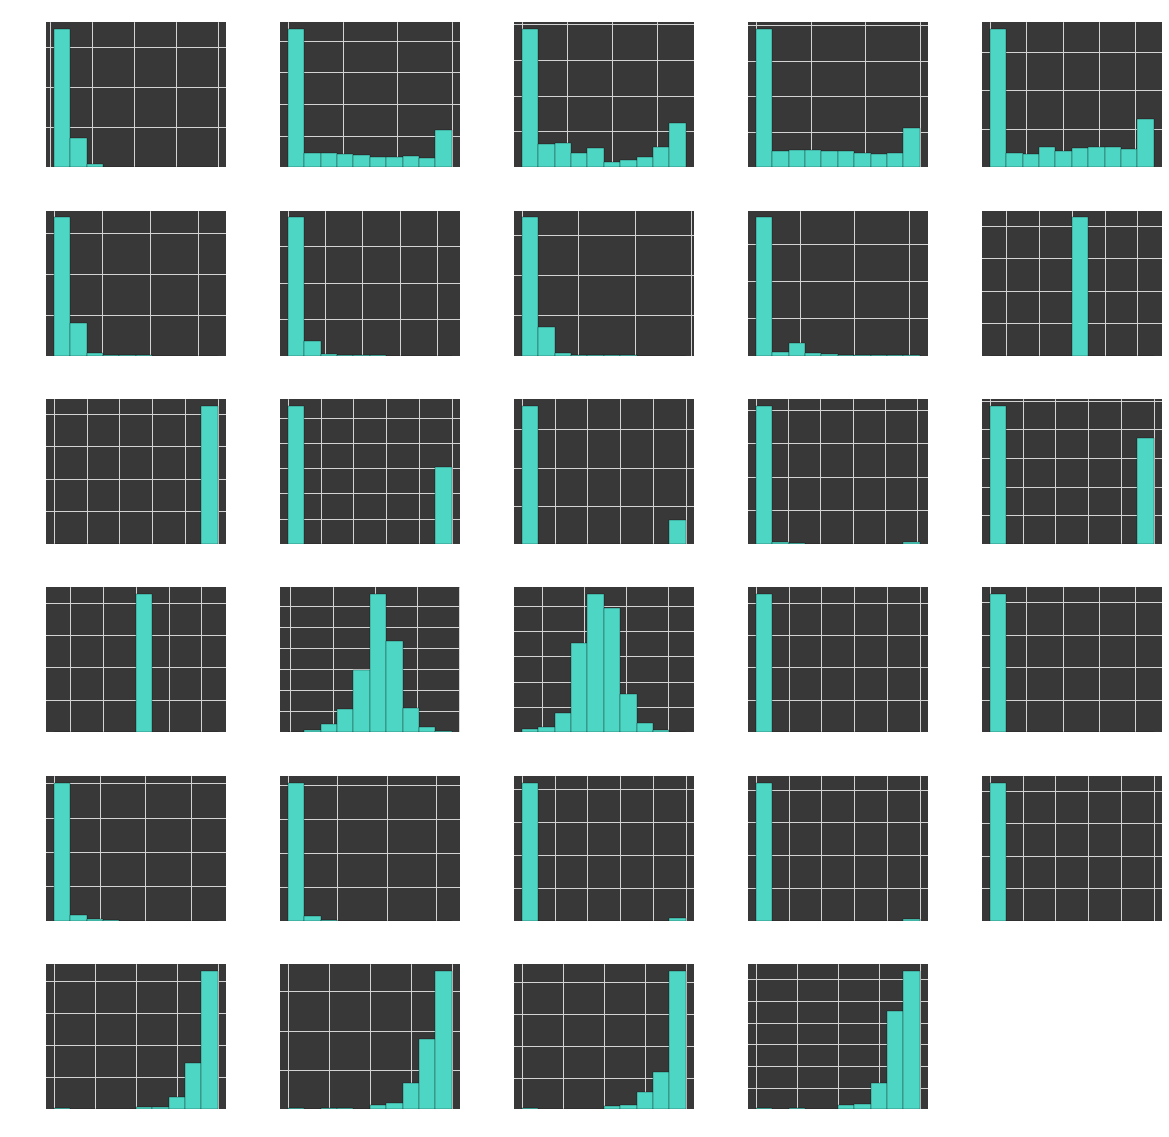

In [126]:
# Replacing columns with f/t with 0/1
df.replace({'f': 0, 't': 1}, inplace=True)

# Plotting the distribution of numerical and boolean categories
df.hist(figsize=(20,20),color=(.3, .84, .77), edgecolor='k', linewidth=0.3);

### to do
We will drop anything that doesn't have adequate classes


In [0]:
df.drop(['has_availability', 'host_has_profile_pic', 'is_business_travel_ready', 'require_guest_phone_verification', 'require_guest_profile_picture', 'requires_license'], axis=1, inplace=True)
# df.dropna(subset=['host_since'], inplace=True)
# df.drop('bed_type', axis=1, inplace=True)
df.drop('calendar_updated', axis=1, inplace=True)

In [128]:
print(df.experiences_offered.value_counts())
df.drop('experiences_offered', axis=1, inplace=True)

none        83388
business      582
family        479
social        411
romantic      208
Name: experiences_offered, dtype: int64


## Cleaning Data Columns:

In [129]:
# Converting to datetime
df.host_since = pd.to_datetime(df.host_since) 

# Calculating the number of days
df['host_days_active'] = (datetime.now() - df.host_since).astype('timedelta64[D]')

# Printing mean and median
print("Mean days as host:", round(df['host_days_active'].mean(),0))
print("Median days as host:", df['host_days_active'].median())

# Replacing null values with the median
df.host_days_active.fillna(df.host_days_active.median(), inplace=True)

Mean days as host: 1566.0
Median days as host: 1578.0


Null values: 25900
Proportion: 30.4%
-- -- --


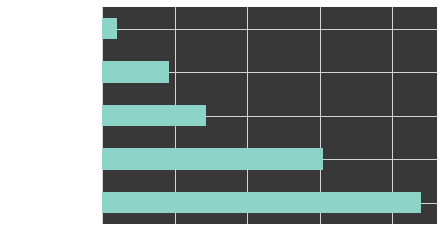

In [130]:
print("Null values:", df.host_response_time.isna().sum())
print(f"Proportion: {round((df.host_response_time.isna().sum()/len(df))*100, 1)}%")

# # Number of rows without a value for host_response_time which have also not yet had a review
len(df[df[['host_response_time', 'first_review']].isnull().sum(axis=1) == 2])
df.host_response_time.fillna("unknown", inplace=True)
print("-- -- --")
df.host_response_time.value_counts(normalize=True).plot(kind='barh')

In [131]:
# Removing the % sign from the host_response_rate string and converting to an integer
df.host_response_rate = df.host_response_rate.str[:-1].astype('float64')
# Bin into four categories
df.host_response_rate = pd.cut(df.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

# Converting to string
df.host_response_rate = df.host_response_rate.astype('str')

# Replace nulls with 'unknown'
df.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
df.host_response_rate.value_counts()

100%       39938
unknown    25900
50-89%      9194
90-99%      7675
0-49%       2361
Name: host_response_rate, dtype: int64

### Property Type

In [132]:
df.property_type.value_counts()

Apartment                 56265
House                     17879
Condominium                2984
Townhouse                  2983
Serviced apartment         1489
Loft                        745
Bed and breakfast           645
Guest suite                 366
Guesthouse                  305
Boutique hotel              235
Other                       199
Hostel                      187
Hotel                       162
Bungalow                    138
Cottage                      92
Tiny house                   65
Boat                         61
Villa                        59
Aparthotel                   49
Houseboat                    35
Cabin                        20
Camper/RV                    17
Earth house                  16
Chalet                       12
Hut                          11
Barn                          8
Casa particular (Cuba)        7
Farm stay                     6
Yurt                          5
Tent                          4
Dome house                    3
Treehous

In [0]:
# Replacing categories that are types of houses or apartments
df.property_type.replace({
    'Townhouse': 'House',
    'Serviced apartment': 'Apartment',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Chalet': 'House'  
    }, inplace=True)

    # 'Tiny house': 'House',
    # 'Earth house': 'House',

# Replacing other categories with 'other'
df.loc[~df.property_type.isin(['House', 'Apartment']), 'property_type'] = 'Other'



In [0]:
for col in ['bathrooms', 'bedrooms', 'beds']:
    df[col].fillna(df[col].median(), inplace=True)

### Amenities

In [135]:
# Creating a set of all possible amenities
amenities_list = list(df.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
amenities_set

{'',
 '24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Air purifier',
 'Alfresco bathtub',
 'Amazon Echo',
 'Apple TV',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Balcony',
 'Bath towel',
 'Bathroom essentials',
 'Bathtub',
 'Bathtub with bath chair',
 'Beach essentials',
 'Beach view',
 'Beachfront',
 'Bed linens',
 'Bedroom comforts',
 'Bidet',
 'Body soap',
 'Breakfast',
 'Breakfast bar',
 'Breakfast table',
 'Building staff',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Ceiling fan',
 'Ceiling fans',
 'Ceiling hoist',
 'Central air conditioning',
 'Changing table',
 'Charcoal barbeque',
 "Chef's kitchen",
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Convection oven',
 'Cooking basics',
 'Crib',
 'DVD player',
 'Day bed',
 'Dining area',
 'Dining table',
 'Disabled parking spot',
 'Dishes and silverware'

In the list above, some amenities are more important than others (e.g. a balcony is more likely to increase price than a fax machine), and some are likely to be fairly uncommon (e.g. 'Electric profiling bed'). Based on previous experience working in the Airbnb property management industry, and research into which amenities are considered by guests to be more important, a selection of the more important amenities will be extracted. These will be further investigated in the EDA section. For example, if it turns out that almost all properties have/do not have a particular amenity, that feature will not be very useful in helping explain differences in prices.

The amenities chosen are (slashes indicate separate categories that can be combined):
- 24-hour check-in
- Air conditioning/central air conditioning
- Amazon Echo/Apple TV/DVD player/game console/Netflix/projector and screen/smart TV (i.e. non-basic electronics)
- BBQ grill/fire pit/propane barbeque
- Balcony/patio or balcony
- Beach view/beachfront/lake access/mountain view/ski-in ski-out/waterfront (i.e. great location/views)
- Bed linens
- Breakfast
- Cable TV/TV
- Coffee maker/espresso machine
- Cooking basics
- Dishwasher/Dryer/Washer/Washer and dryer
- Elevator
- Exercise equipment/gym/private gym/shared gym
- Family/kid friendly, or anything containing 'children'
- Free parking on premises/free street parking/outdoor parking/paid parking off premises/paid parking on premises
- Garden or backyard/outdoor seating/sun loungers/terrace
- Host greets you
- Hot tub/jetted tub/private hot tub/sauna/shared hot tub/pool/private pool/shared pool
- Internet/pocket wifi/wifi
- Long term stays allowed
- Pets allowed/cat(s)/dog(s)/pets live on this property/other pet(s)
- Private entrance
- Safe/security system
- Self check-in
- Smoking allowed
- Step-free access/wheelchair accessible, or anything containing 'accessible'
- Suitable for events

In [136]:
df.loc[df['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
df.loc[df['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
df.loc[df['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
df.loc[df['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
df.loc[df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
df.loc[df['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
df.loc[df['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
df.loc[df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
df.loc[df['amenities'].str.contains('TV'), 'tv'] = 1
df.loc[df['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
df.loc[df['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
df.loc[df['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
df.loc[df['amenities'].str.contains('Elevator'), 'elevator'] = 1
df.loc[df['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
df.loc[df['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
df.loc[df['amenities'].str.contains('parking'), 'parking'] = 1
df.loc[df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
df.loc[df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
df.loc[df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
df.loc[df['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
df.loc[df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
df.loc[df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
df.loc[df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
df.loc[df['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
df.loc[df['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
df.loc[df['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
df.loc[df['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
df.loc[df['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [137]:
# Replacing nulls with zeros for new columns
# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in df.iloc[:,41:].columns:
    if df[col].sum() < len(df)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
df.drop(infrequent_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
df.drop('amenities', axis=1, inplace=True)

['high_end_electronics', 'bbq', 'nature_and_views', 'gym', 'hot_tub_sauna_or_pool', 'secure', 'smoking_allowed', 'accessible', 'event_suitable']


### Price

AxesSubplot(0.125,0.125;0.775x0.755)


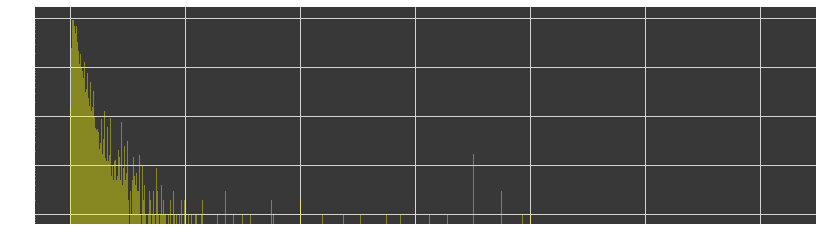

In [138]:
plt.figure(figsize=(14,4))
plt.yscale('log')
try:
  df.price = df.price.str[1:-3]
  df.price = df.price.str.replace(",", "")
  df.price = df.price.astype('int64')
  print(sns.distplot(df.price.values,bins=1000,color='yellow', kde=False));
except:
  print(sns.distplot(df.price.values,bins=1000,color='yellow', kde=False));
  pass

In [0]:
df.drop(df[df.price > 1000].index, inplace=True)

### Security Deposit

AxesSubplot(0.125,0.125;0.775x0.755)


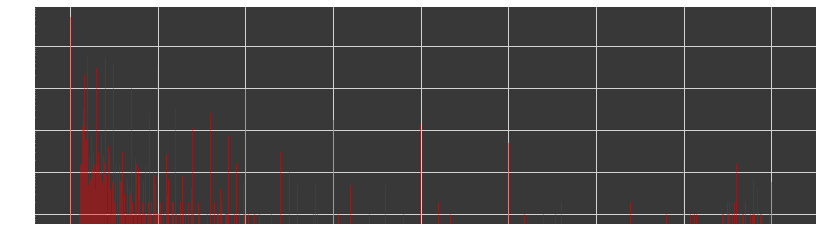

In [140]:
df.security_deposit = df.security_deposit.str[1:-3]
df.security_deposit = df.security_deposit.str.replace(",", "")
df.security_deposit.fillna(0, inplace=True)
df.security_deposit = df.security_deposit.astype('int64')
plt.figure(figsize=(14,4))
plt.yscale('log')
print(sns.distplot(df.security_deposit.values,bins=1000,color='red', kde=False));

### Cleaning Fee


In [0]:

df.cleaning_fee = df.cleaning_fee.str[1:-3]
df.cleaning_fee = df.cleaning_fee.str.replace(",", "")
df.cleaning_fee.fillna(0, inplace=True)
df.cleaning_fee = df.cleaning_fee.astype('int64')

### Extra People

In [0]:
df.extra_people = df.extra_people.str[1:-3]
df.extra_people = df.extra_people.str.replace(",", "")
df.extra_people.fillna(0, inplace=True)
df.extra_people = df.extra_people.astype('int64')

### First Review

In [0]:
df.first_review = pd.to_datetime(df.first_review) # Converting to datetime

# Calculating the number of days between the first review and the date the data was scraped
df['time_since_first_review'] = (datetime.now() - df.first_review).astype('timedelta64[D]')

In [144]:
df[df['first_review'].isnull()==True][['time_since_first_review']].shape

(19850, 1)

In [0]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].fillna(na_label, inplace=True)

In [0]:
# Binning time since first review
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(df.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

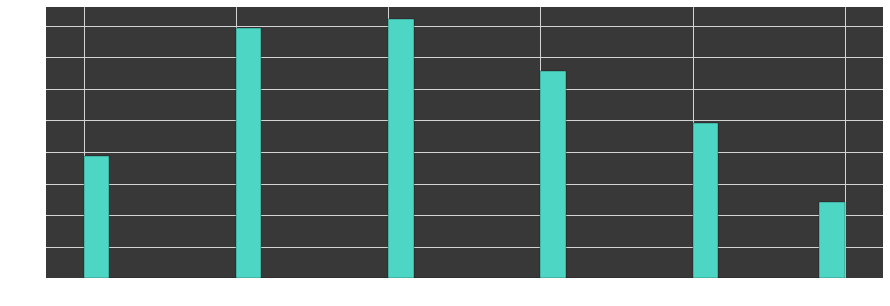

In [147]:
# Distribution of the number of days since first review
df.time_since_first_review.hist(figsize=(15,5), bins=30, color=(.3, .84, .77), edgecolor='k');

In [0]:
df.drop('first_review', axis=1, inplace=True)
df.drop(['time_since_first_review'], axis=1, inplace=True)

### Last Review

In [0]:
df.last_review = pd.to_datetime(df.last_review) # Converting to datetime

# Calculating the number of days between the most recent review and the date the data was scraped
df['time_since_last_review'] = (datetime.now() - df.last_review).astype('timedelta64[D]')

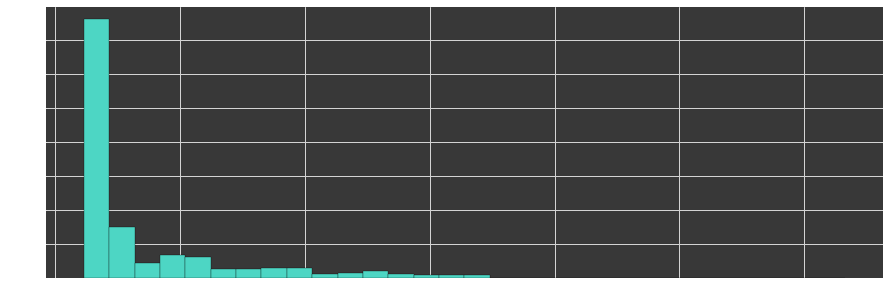

In [150]:
# Distribution of the number of days since last review
df.time_since_last_review.hist(figsize=(15,5), bins=30,color=(.3, .84, .77),edgecolor='k');

In [0]:
# Binning time since last review
bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(df.time_since_last_review)],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'],
           na_label='no reviews')

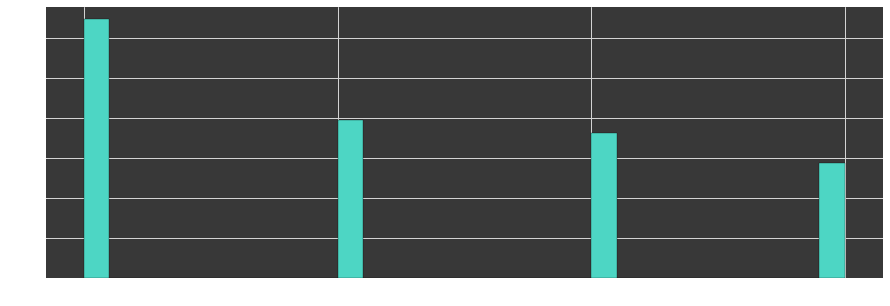

In [152]:
# Distribution of the number of days since first review
df.time_since_last_review.hist(figsize=(15,5), bins=30, color=(.3, .84, .77),edgecolor='k');

In [0]:
# Dropping last_review - first_review will be kept for EDA and dropped later
df.drop('last_review', axis=1, inplace=True)
df.drop(['time_since_last_review'], axis=1, inplace=True)

### Review Ratings


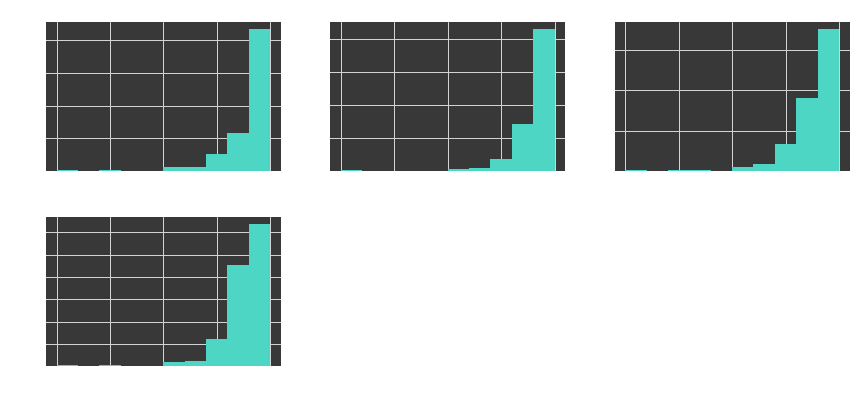

In [154]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(df.columns[df.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    df[var_name].hist(bins=10,ax=ax,color=(.3, .84, .77))
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [0]:
# Creating a list of all review columns that are scored out of 10
variables_to_plot.pop(0)

# Binning for all columns scored out of 10
for col in variables_to_plot:
    bin_column(col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')
# Binning column scored out of 100
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

### Cancelation Policy

In [156]:
df.cancellation_policy.value_counts()

strict_14_with_grace_period    36685
flexible                       27225
moderate                       19990
super_strict_60                  506
super_strict_30                  375
strict                             8
luxury_moderate                    6
luxury_super_strict_95             3
Name: cancellation_policy, dtype: int64

In [0]:
# Replacing categories
df.cancellation_policy.replace({
    'super_strict_30': 'strict_14_with_grace_period',
    'super_strict_60': 'strict_14_with_grace_period',
    'strict': 'strict_14_with_grace_period',
    'luxury_moderate': 'moderate'
    }, inplace=True)

In [0]:
df.drop(['number_of_reviews_ltm'], axis=1, inplace=True)
df.drop('host_since', axis=1, inplace=True)
# df.drop('amenities', axis=1, inplace=True)

In [159]:
df.host_is_superhost.value_counts()

0.0    72071
1.0    12715
Name: host_is_superhost, dtype: int64

In [160]:
df.info(verbose=True,null_counts=True, )

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84798 entries, 11551 to 39869282
Data columns (total 53 columns):
host_response_time           84798 non-null object
host_response_rate           84798 non-null object
host_is_superhost            84786 non-null float64
host_listings_count          84786 non-null float64
host_identity_verified       84786 non-null float64
neighbourhood_cleansed       84798 non-null object
latitude                     84798 non-null float64
longitude                    84798 non-null float64
property_type                84798 non-null object
room_type                    84798 non-null object
accommodates                 84798 non-null int64
bathrooms                    84798 non-null float64
bedrooms                     84798 non-null float64
beds                         84798 non-null float64
bed_type                     84798 non-null object
price                        84798 non-null int64
security_deposit             84798 non-null int64
cleaning_fee

In [0]:
df.fillna(0, inplace=True)


In [162]:
df.rename(columns={'neighbourhood_cleansed':'borough'},inplace=True)
df.info(verbose=True,null_counts=True, )

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84798 entries, 11551 to 39869282
Data columns (total 53 columns):
host_response_time           84798 non-null object
host_response_rate           84798 non-null object
host_is_superhost            84798 non-null float64
host_listings_count          84798 non-null float64
host_identity_verified       84798 non-null float64
borough                      84798 non-null object
latitude                     84798 non-null float64
longitude                    84798 non-null float64
property_type                84798 non-null object
room_type                    84798 non-null object
accommodates                 84798 non-null int64
bathrooms                    84798 non-null float64
bedrooms                     84798 non-null float64
beds                         84798 non-null float64
bed_type                     84798 non-null object
price                        84798 non-null int64
security_deposit             84798 non-null int64
cleaning_fee

In [0]:
df.to_csv('/content/drive/My Drive/data/processed_data/processed.csv')

In [0]:
df_dummies=pd.get_dummies(df)
# df_dummies.to_csv('/content/drive/My Drive/data/processed_data/london_dummy.csv')

In [99]:
df_dummies.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84798 entries, 11551 to 39869282
Data columns (total 117 columns):
host_is_superhost                                  84798 non-null float64
host_listings_count                                84798 non-null float64
host_identity_verified                             84798 non-null float64
latitude                                           84798 non-null float64
longitude                                          84798 non-null float64
accommodates                                       84798 non-null int64
bathrooms                                          84798 non-null float64
bedrooms                                           84798 non-null float64
beds                                               84798 non-null float64
price                                              84798 non-null int64
security_deposit                                   84798 non-null int64
cleaning_fee                                       84798 non-null int64
gue

## Profile Final Data Set

In [100]:
!pip install pandas-profiling[notebook,html]

In [0]:
from pandas_profiling import ProfileReport

In [104]:
profile = ProfileReport(df_dummies)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [0]:
profile.to_file('/content/drive/My Drive/data/london-pp.html')